In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 3.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Sun Apr 30 07:14:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [6]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE=[224,224]

train_path='/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/train'
val_path='/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/valid'

In [8]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

234545216/234545216 [==============================] - 2s 0us/step


In [9]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [10]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/New_Plant_Diseases_Dataset/train/**')

In [11]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [12]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/New_Plant_Diseases_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [17]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/New_Plant_Diseases_Dataset/valid',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
144/144 [==============================] - 4672s 32s/step - loss: 2.8235 - accuracy: 0.7594 - val_loss: 1.1029 - val_accuracy: 0.8661
Epoch 2/10
144/144 [==============================] - 322s 2s/step - loss: 0.8679 - accuracy: 0.8838 - val_loss: 1.0965 - val_accuracy: 0.8746
Epoch 3/10
144/144 [==============================] - 323s 2s/step - loss: 0.7521 - accuracy: 0.9087 - val_loss: 1.1615 - val_accuracy: 0.8824
Epoch 4/10
144/144 [==============================] - 320s 2s/step - loss: 0.6731 - accuracy: 0.9203 - val_loss: 1.0662 - val_accuracy: 0.8997
Epoch 5/10
144/144 [==============================] - 317s 2s/step - loss: 0.6320 - accuracy: 0.9332 - val_loss: 1.0299 - val_accuracy: 0.9128
Epoch 6/10
144/144 [==============================] - 321s 2s/step - loss: 0.6414 - accuracy: 0.9339 - val_loss: 0.8313 - val_accuracy: 0.9287
Epoch 7/10
144/144 [==============================] - 322s 2s/step - loss: 0.6332 - accuracy: 0.9389 - val_loss: 0.9681 - val_accuracy: 0.92

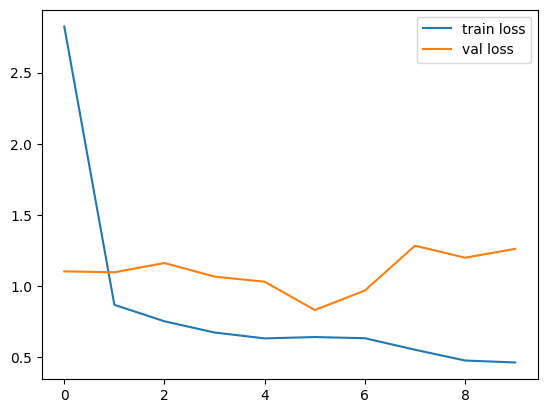

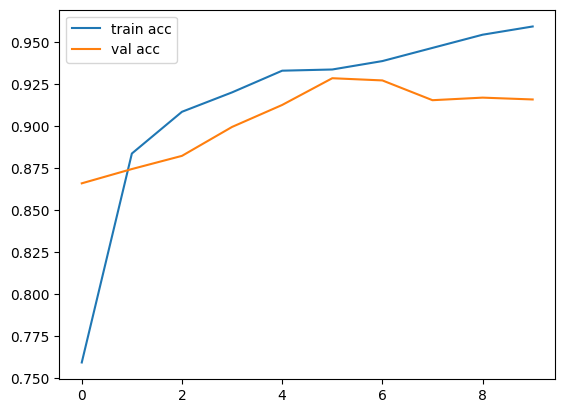

<Figure size 640x480 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal16_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal16_acc')

In [20]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet16.h5')

In [21]:
y_pred = model.predict(test_set)

36/36 [==============================] - 35s 900ms/step


In [22]:
y_pred

array([[1.0000000e+00, 6.6747732e-36, 2.3578133e-30, ..., 1.2825682e-35,
        0.0000000e+00, 0.0000000e+00],
       [3.2553480e-20, 1.9091398e-14, 1.2947660e-25, ..., 0.0000000e+00,
        0.0000000e+00, 2.1950504e-38],
       [0.0000000e+00, 0.0000000e+00, 1.6320978e-19, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [5.4593250e-18, 1.3871609e-15, 1.7994091e-10, ..., 1.5190718e-28,
        1.0000000e+00, 1.6069092e-21],
       [6.6461562e-31, 2.4405986e-28, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [23]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [24]:
y_pred

array([0, 6, 4, ..., 9, 8, 2])

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [26]:
model=load_model('model_resnet16.h5')

In [27]:
img=image.load_img('/content/drive/MyDrive/New_Plant_Diseases_Dataset/valid/Tomato___Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG',target_size=(224,224))

In [28]:
x=image.img_to_array(img)
x


array([[[182., 172., 171.],
        [181., 171., 170.],
        [184., 174., 173.],
        ...,
        [176., 170., 170.],
        [171., 165., 165.],
        [184., 178., 178.]],

       [[181., 171., 170.],
        [181., 171., 170.],
        [183., 173., 172.],
        ...,
        [175., 169., 169.],
        [168., 162., 162.],
        [180., 174., 174.]],

       [[182., 172., 171.],
        [184., 174., 173.],
        [186., 176., 175.],
        ...,
        [183., 177., 177.],
        [174., 168., 168.],
        [187., 181., 181.]],

       ...,

       [[114., 105.,  90.],
        [120., 110.,  98.],
        [138., 125., 116.],
        ...,
        [117., 105., 105.],
        [116., 105., 109.],
        [117., 106., 114.]],

       [[115., 106.,  89.],
        [117., 108.,  93.],
        [133., 121., 109.],
        ...,
        [118., 106., 106.],
        [120., 109., 115.],
        [119., 108., 116.]],

       [[118., 110.,  91.],
        [116., 107.,  90.],
        [130., 1

In [29]:
x.shape

(224, 224, 3)

In [30]:
x=x/255

In [31]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [32]:
model.predict(img_data)

1/1 [==============================] - 4s 4s/step


array([[9.97610277e-06, 1.14502769e-03, 9.37529922e-01, 1.20724515e-04,
        5.64442277e-02, 5.61612712e-09, 7.87556055e-04, 3.87361902e-03,
        5.26795011e-05, 3.63841791e-05]], dtype=float32)

In [33]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 32ms/step


In [34]:
a==1

array([False])